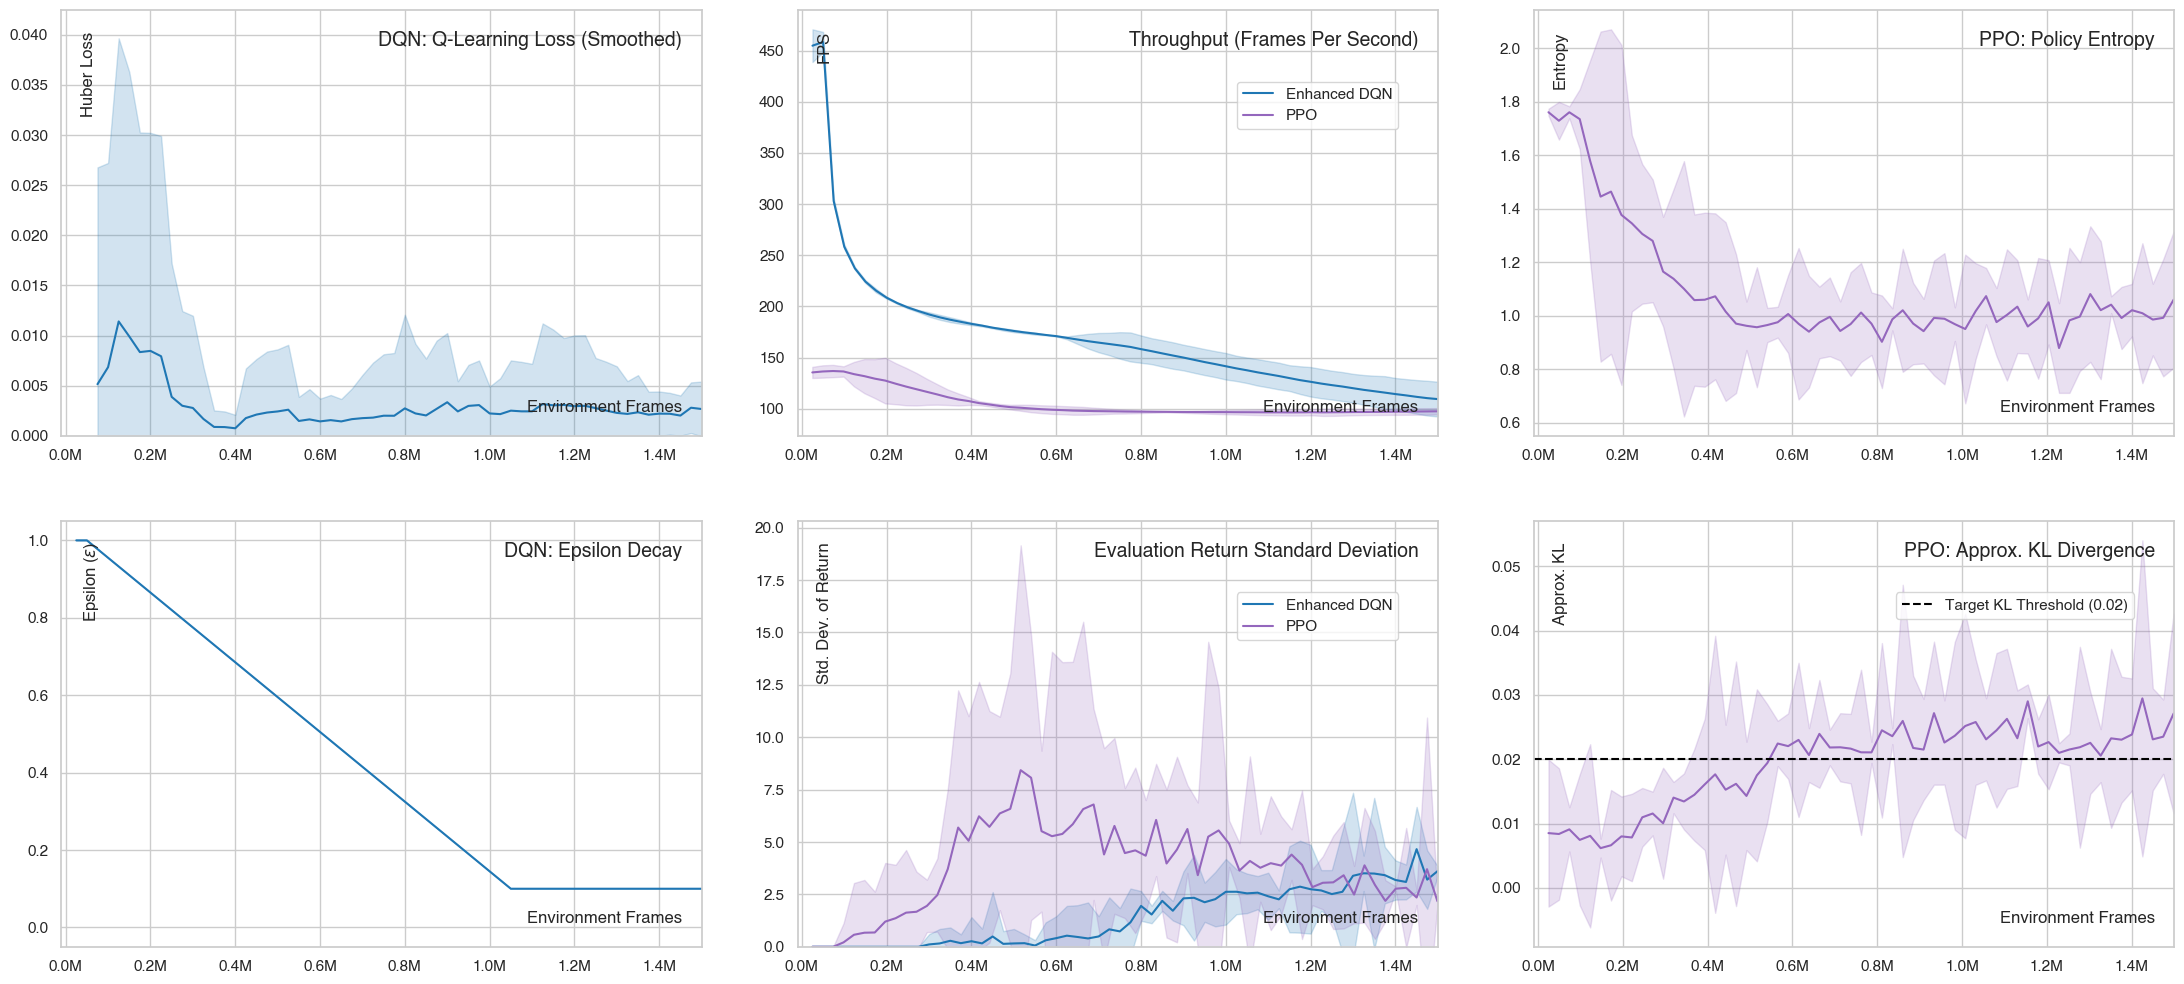


Diagnostic plot generated successfully in the notebook.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# --- Configuration ---
SEEDS = [42, 84, 126]
AGENTS_TO_PLOT = {
    'dqn_enhanced': 'Enhanced DQN',
    'ppo': 'PPO'
}
OUTPUT_DIR = '../output' 
FIG_WIDTH = 22
FIG_HEIGHT = 10
AGENT_COLORS = {
    'dqn_enhanced': '#1f77b4', 
    'ppo': '#9467bd'
}

# --- Styling ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (FIG_WIDTH, FIG_HEIGHT)
plt.rcParams['font.family'] = 'Helvetica'

# --- Data Loading and Processing ---
def load_and_process_data(agents, seeds):
    """Loads and aggregates data for specified agents and seeds."""
    all_data = {}
    for agent_id, agent_name in agents.items():
        agent_dfs = []
        for seed in seeds:
            try:
                filepath = f"{OUTPUT_DIR}/{agent_id}_{seed}/results/metrics.csv"
                df = pd.read_csv(filepath)
                df['seed'] = seed
                agent_dfs.append(df)
            except FileNotFoundError:
                print(f"Warning: Could not find data for {agent_id} with seed {seed} at {filepath}")
        
        if not agent_dfs:
            print(f"ERROR: No data found for agent '{agent_id}'. Skipping.")
            continue
            
        full_df = pd.concat(agent_dfs, ignore_index=True)
        all_data[agent_id] = full_df
        
    return all_data

def get_stats(df, metric_col):
    """Calculates mean and 95% CI for a given metric across seeds."""
    grouped = df.groupby('environment_frame')[metric_col]
    
    mean = grouped.mean()
    std = grouped.std()
    count = grouped.count()
    
    t_crit = 4.303 # t-critical value for 95% CI with n=3 (df=2)
    ci = t_crit * (std / np.sqrt(count))
    
    stats_df = pd.DataFrame({
        'mean': mean,
        'ci_lower': mean - ci,
        'ci_upper': mean + ci
    }).reset_index()
    
    return stats_df

# Load data for all agents
data = load_and_process_data(AGENTS_TO_PLOT, SEEDS)

# --- Plotting ---
fig, axes = plt.subplots(2, 3, figsize=(FIG_WIDTH, FIG_HEIGHT))

# Row 1, Col 1: DQN Q-Learning Loss
ax = axes[0, 0]
if 'dqn_enhanced' in data:
    dqn_loss_stats = get_stats(data['dqn_enhanced'].dropna(subset=['q_learning_loss']), 'q_learning_loss')
    # Smooth the noisy loss signal for better visualization
    dqn_loss_stats['mean_smoothed'] = dqn_loss_stats['mean'].rolling(5, min_periods=1).mean()
    dqn_loss_stats['ci_lower_smoothed'] = dqn_loss_stats['ci_lower'].rolling(5, min_periods=1).mean()
    dqn_loss_stats['ci_upper_smoothed'] = dqn_loss_stats['ci_upper'].rolling(5, min_periods=1).mean()
    ax.plot(dqn_loss_stats['environment_frame'], dqn_loss_stats['mean_smoothed'], color=AGENT_COLORS['dqn_enhanced'])
    ax.fill_between(dqn_loss_stats['environment_frame'], dqn_loss_stats['ci_lower_smoothed'], dqn_loss_stats['ci_upper_smoothed'], alpha=0.2, color=AGENT_COLORS['dqn_enhanced'])
ax.set_ylim(bottom=0)

# Row 1, Col 2: Shared FPS
ax = axes[0, 1]
if 'dqn_enhanced' in data:
    dqn_fps_stats = get_stats(data['dqn_enhanced'], 'fps')
    ax.plot(dqn_fps_stats['environment_frame'], dqn_fps_stats['mean'], color=AGENT_COLORS['dqn_enhanced'], label='Enhanced DQN')
    ax.fill_between(dqn_fps_stats['environment_frame'], dqn_fps_stats['ci_lower'], dqn_fps_stats['ci_upper'], alpha=0.2, color=AGENT_COLORS['dqn_enhanced'])
if 'ppo' in data:
    ppo_fps_stats = get_stats(data['ppo'], 'fps')
    ax.plot(ppo_fps_stats['environment_frame'], ppo_fps_stats['mean'], color=AGENT_COLORS['ppo'], label='PPO')
    ax.fill_between(ppo_fps_stats['environment_frame'], ppo_fps_stats['ci_lower'], ppo_fps_stats['ci_upper'], alpha=0.2, color=AGENT_COLORS['ppo'])
ax.legend(loc='upper right', bbox_to_anchor=(0.95, 0.85)) # CORRECTED: Moved legend down

# Row 1, Col 3: PPO Policy Entropy
ax = axes[0, 2]
if 'ppo' in data:
    ppo_entropy_stats = get_stats(data['ppo'], 'entropy')
    ax.plot(ppo_entropy_stats['environment_frame'], ppo_entropy_stats['mean'], color=AGENT_COLORS['ppo'])
    ax.fill_between(ppo_entropy_stats['environment_frame'], ppo_entropy_stats['ci_lower'], ppo_entropy_stats['ci_upper'], alpha=0.2, color=AGENT_COLORS['ppo'])

# Row 2, Col 1: DQN Epsilon Decay
ax = axes[1, 0]
if 'dqn_enhanced' in data:
    dqn_epsilon_stats = get_stats(data['dqn_enhanced'], 'epsilon')
    ax.plot(dqn_epsilon_stats['environment_frame'], dqn_epsilon_stats['mean'], color=AGENT_COLORS['dqn_enhanced'])
    ax.fill_between(dqn_epsilon_stats['environment_frame'], dqn_epsilon_stats['ci_lower'], dqn_epsilon_stats['ci_upper'], alpha=0.2, color=AGENT_COLORS['dqn_enhanced'])
ax.set_ylim(-0.05, 1.05)

# Row 2, Col 2: Shared Eval Std Return
ax = axes[1, 1]
if 'dqn_enhanced' in data:
    dqn_std_stats = get_stats(data['dqn_enhanced'], 'eval_std_return')
    ax.plot(dqn_std_stats['environment_frame'], dqn_std_stats['mean'], color=AGENT_COLORS['dqn_enhanced'], label='Enhanced DQN')
    ax.fill_between(dqn_std_stats['environment_frame'], dqn_std_stats['ci_lower'], dqn_std_stats['ci_upper'], alpha=0.2, color=AGENT_COLORS['dqn_enhanced'])
if 'ppo' in data:
    ppo_std_stats = get_stats(data['ppo'], 'eval_std_return')
    ax.plot(ppo_std_stats['environment_frame'], ppo_std_stats['mean'], color=AGENT_COLORS['ppo'], label='PPO')
    ax.fill_between(ppo_std_stats['environment_frame'], ppo_std_stats['ci_lower'], ppo_std_stats['ci_upper'], alpha=0.2, color=AGENT_COLORS['ppo'])
ax.legend(loc='upper right', bbox_to_anchor=(0.95, 0.85)) # CORRECTED: Moved legend down
ax.set_ylim(bottom=0)

# Row 2, Col 3: PPO Approximate KL Divergence
ax = axes[1, 2]
if 'ppo' in data:
    ppo_kl_stats = get_stats(data['ppo'], 'approx_kl')
    ax.plot(ppo_kl_stats['environment_frame'], ppo_kl_stats['mean'], color=AGENT_COLORS['ppo'])
    ax.fill_between(ppo_kl_stats['environment_frame'], ppo_kl_stats['ci_lower'], ppo_kl_stats['ci_upper'], alpha=0.2, color=AGENT_COLORS['ppo'])
    ax.axhline(0.02, color='black', linestyle='--', label='Target KL Threshold (0.02)')
    ax.legend(loc='upper right', bbox_to_anchor=(0.95, 0.85))

# --- Titles and Labels ---
titles = [
    'DQN: Q-Learning Loss (Smoothed)', 'Throughput (Frames Per Second)', 'PPO: Policy Entropy',
    'DQN: Epsilon Decay', 'Evaluation Return Standard Deviation', 'PPO: Approx. KL Divergence'
]
y_labels = ['Huber Loss', 'FPS', 'Entropy', 'Epsilon ($\epsilon$)', 'Std. Dev. of Return', 'Approx. KL']

for i, ax in enumerate(axes.flat):
    # Title inside top-right
    ax.text(0.97, 0.95, titles[i], transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
    # Y-axis label inside top-left
    ax.text(0.03, 0.95, y_labels[i], transform=ax.transAxes, rotation=90, va='top', ha='left', fontsize=12)
    # X-axis label inside bottom-right
    ax.text(0.97, 0.05, 'Environment Frames', transform=ax.transAxes, ha='right', va='bottom', fontsize=12)
    
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.set_xlim(-10000, 1.5e6)
    
    # Remove default external labels
    ax.set_xlabel('')
    ax.set_ylabel('')

# Adjust layout for a compact fit
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.15)

# Display the final plot
plt.show()

print("\nDiagnostic plot generated successfully in the notebook.")